In [1291]:
import os
import json
import cv2
import random
from statistics import mean, median
import seaborn as sns
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter

path = '/opt/ml/detection/dataset'

In [1475]:
cat = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
color = {
    0: (230, 75, 75), # red
    1: (245, 130, 48), # orange
    2: (255, 255, 25), # yellow 
    3: (210, 245, 60), # lime
    4: (60, 180, 75), # green
    5: (70, 240, 240), #sky blue 
    6: (0, 130, 200), # blue
    7: (145, 30, 180), # purple
    8: (240, 50, 230), # pink
    9: (128, 0, 0) # Brown
}
train_images = glob(path + '/train/*')
test_images = glob(path + '/test/*')

with open(path + '/train.json', 'r') as j:
    train_json = json.load(j)
    
with open(path + '/test.json', 'r') as j:
    test_json = json.load(j)

In [1476]:
# with open('./stratified_kfold/basic/cv_train_1.json', 'r') as j:
#     train_json = json.load(j)

# with open('./stratified_kfold/basic/cv_val_1.json', 'r') as j:
#     valid_json = json.load(j)

---

<font color='blue'>

# 1. json file 분석

- 총 5개의 key 존재가 존재합니다.
    - 1.1 `info`, `licenses`
    - 1.2 `images`
    - 1.3 `categories`
    - 1.4 `annotattions`
</font>

In [1477]:
for i, key in enumerate(train_json.keys(), start=1):
    print(f"{i}. {key}")

1. info
2. licenses
3. images
4. categories
5. annotations


<font color='blue'>

## 1.1 `info`, `licenses`


- 데이터 생성 날짜 등 데이터에 대한 간단한 설명이 있습니다.

</font>

In [1478]:
train_json['info'], train_json['licenses']

({'year': 2021,
  'version': '1.0',
  'description': 'Recycle Trash',
  'contributor': 'Upstage',
  'url': None,
  'date_created': '2021-02-02 01:10:00'},
 [{'id': 0,
   'name': 'CC BY 4.0',
   'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}])

<font color='blue'>

## 1.2 `images`
    
- 이미지 한장에 대한 정보입니다.
    - width: 이미지의 너비
    - height: 이미지의 높이
    - file_name: 파일 경로
    - id: 이미지별 unique id

</font>

In [1479]:
print(len(train_json['images']))

4883


In [1480]:
train_json['images'][0]

{'width': 1024,
 'height': 1024,
 'file_name': 'train/0000.jpg',
 'license': 0,
 'flickr_url': None,
 'coco_url': None,
 'date_captured': '2020-12-26 14:44:23',
 'id': 0}

In [1481]:
total_w = []
total_h = []

for i in train_json['images']:
    total_w.append(i['width'])
    total_h.append(i['height'])

In [1482]:
print(set(total_w), set(total_h)) # 모든 데이터의 입력 크기는 (1024, 1024). - test 데이터도 마찬가지.

{1024} {1024}


---

<font color='blue'>
    
## 1.3 `categories`
    
- 이미지에 존재하는 객체의 카테고리 정보
    - 0: General trash
    - 1: Paper
    - 2: Paper pack
    - 3: Metal 
    - 4: Glass
    - 5: Plastic
    - 6: Styrofoam
    - 7: Plastic bag
    - 8: Clothing
  
</font>

In [1483]:
train_json['categories']

[{'id': 0, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 1, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 2, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 3, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 4, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 5, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 6, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 7, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 8, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 9, 'name': 'Clothing', 'supercategory': 'Clothing'}]

---

<font color='blue'>

## 1.4 `annotations`


- 이미지에 존재하는 객체에 대한 정보
    - image_id: `images`의 `id`와 매핑
    - category_id: `categories`의 `id`와 매핑
    - area: bbox 넓이(w*h)
    - bbox: [x, y, w, h]의 리스트 형태로 존재. x,y는 좌상 좌표
    - iscrowd: 데이터 표현 방식
    - id: 해당 객체의 고유 id
- train data 4883개 이미지에 존재하는 전체 객체 수: 23144
    
</font>

In [1484]:
train_json['annotations'][0]

{'image_id': 0,
 'category_id': 0,
 'area': 257301.66,
 'bbox': [197.6, 193.7, 547.8, 469.7],
 'iscrowd': 0,
 'id': 0}

In [1485]:
print(len(train_json['annotations']))

23144


In [1490]:
def draw_bbox(idx, l=5, draw=False, vis_label=True):
    '''
    idx: bounding box id
    이미지 내 하나의 instance만 그리는 함수
    '''
    x,y,w,h = map(int, train_json['annotations'][idx]['bbox'])
    sample_img_id = train_json['annotations'][idx]['image_id']
    file_path = train_json['images'][sample_img_id]['file_name']
    cat_index = train_json['annotations'][idx]['category_id']

    label = cat[cat_index]

    sample_image = cv2.imread(path + '/' + file_path, cv2.IMREAD_COLOR)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    cv2.rectangle(sample_image, (x,y), (x+w, y+h), (0,255,0), l)
    if vis_label:
        cv2.putText(sample_image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

    if draw:
        fig , axes = plt.subplots(1,1)
        fig.set_size_inches(10,10)
        plt.imshow(sample_image)
        plt.show()
        return

    return sample_image, label

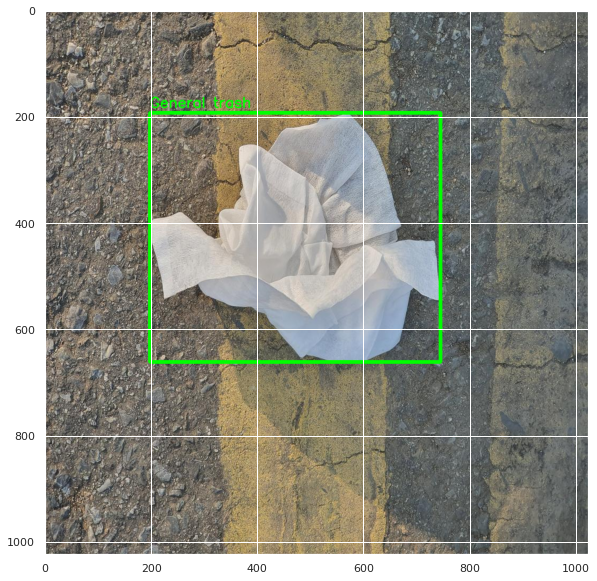

In [1492]:
draw_bbox(0, draw=True)

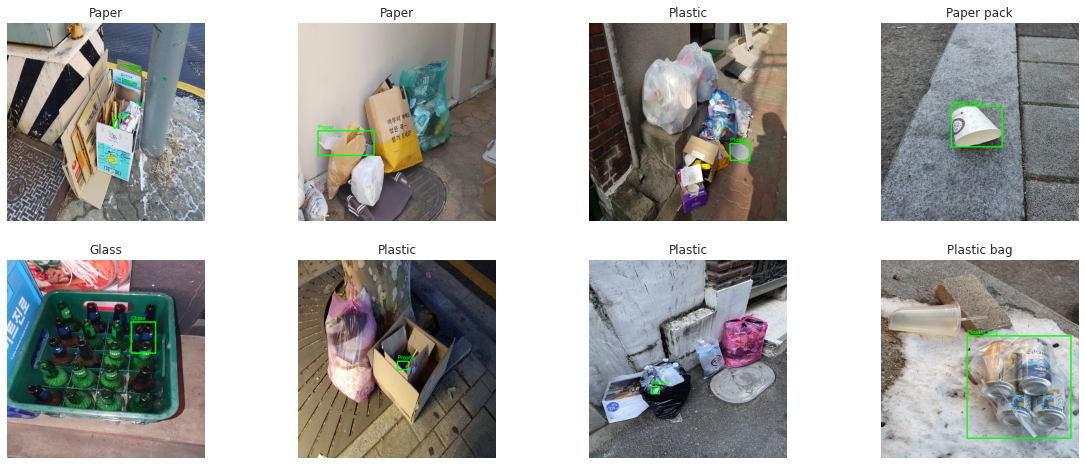

In [1493]:
fig , axes = plt.subplots(2,4)
fig.set_size_inches(20,8)

for i, num in enumerate(random.sample(range(0, len(train_json['annotations'])), 8)):
    img, label = draw_bbox(num)
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(label)
    axes[i//4, i%4].axis('off')

</br>
</br>
</br>
</br>
</br>

---

<font color='red'>

    
# 2. 이미지 데이터 분석

- 2.1 class별 box 개수
- 2.2 이미지별 box 개수(평균, min, max, median)
- 2.3 class별 box 크기(평균, min, max, median)
- 2.4 가장 box 많은 이미지 / 가장 box 적은 이미지 시각화
    
</font>

---

<font color='red'>
    
## 2.1 Class별 box 개수
    
- by<font color='black'>석용님</font>
    
</font>

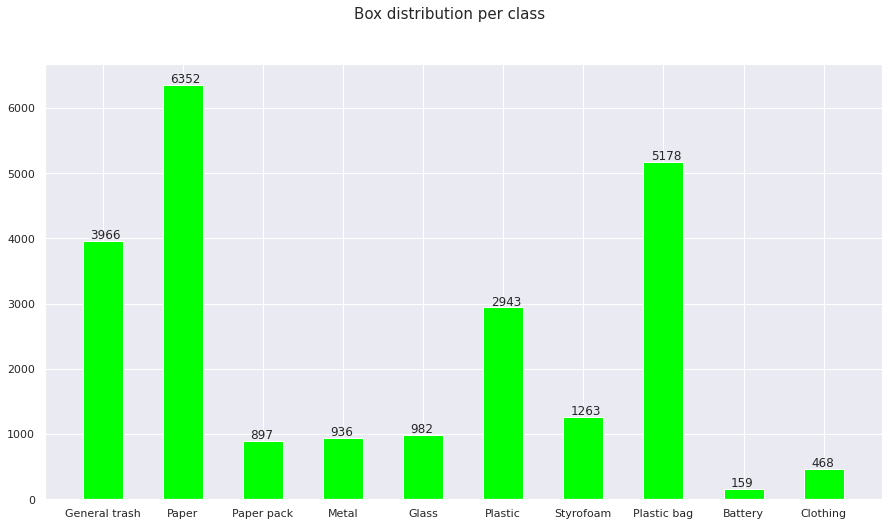

In [1306]:
cat_cnt = [0] * 10

for j in train_json['annotations']:
    cat_cnt[j['category_id']] += 1
    
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.suptitle('Box distribution per class', fontsize=15)

x = np.arange(10)
ax.bar(x, cat_cnt, width=0.5, color='lime')
plt.xticks(x, cat)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.095, p.get_height()+35))

</br>
</br>
</br>
</br>
</br>

---
<font color='red'>


## 2.2 이미지별 box 개수(평균, min, max, median)

    
</font>

In [1359]:
num_boxes_per_image = [0] * len(train_images)
box_size_per_class = {i:[] for i in range(10)}
box_size_total = []
img_id_total = []
cat_total = []
img_size = 1024**2

for i in train_json['annotations']:
    # x,y,w,h = map(int, i['bbox'])
    
    box_size = i['area'] # box 크기
    box_ratio = round(box_size/img_size, 10)
    
    # box 개수 추가
    num_boxes_per_image[i['image_id']] +=1
    
    # class별 box 크기 추가
    box_size_per_class[i['category_id']].append(box_ratio)
    
    # box 크기 
    box_size_total.append(box_ratio)
    img_id_total.append(i['image_id'])
    
    # label
    cat_total.append(i['category_id'])

print('Done')

Done


In [1308]:
box_count_mean = mean(num_boxes_per_image)
box_count_min = min(num_boxes_per_image)
box_count_max = max(num_boxes_per_image)
box_count_median = median(num_boxes_per_image)

print("이미지별 box 개수 평균: {:.1f}\n".format(box_count_mean) +
      "이미지별 box 개수 min: {}\n".format(box_count_min) +
      "이미지별 box 개수 max: {}\n".format(box_count_max) +
      "이미지별 box 개수 median: {}\n".format(box_count_median))

이미지별 box 개수 평균: 4.7
이미지별 box 개수 min: 1
이미지별 box 개수 max: 71
이미지별 box 개수 median: 2



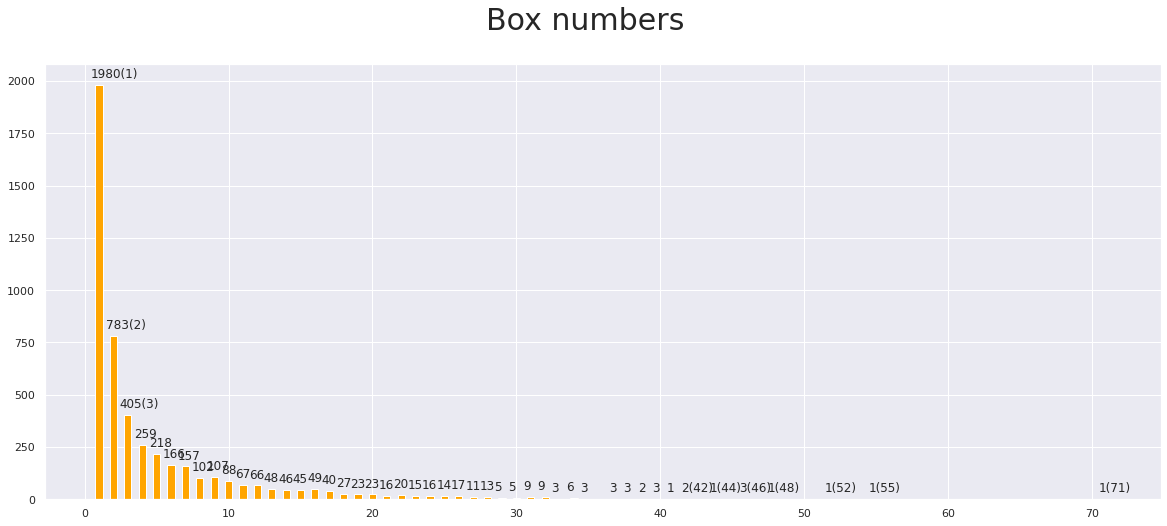

In [1309]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
fig.suptitle('Box numbers', fontsize=30)

counter = Counter(num_boxes_per_image)
counter = sorted(counter.items())
counter_item = [i[1] for i in counter]
counter_key = [i[0] for i in counter]

x = np.unique(num_boxes_per_image)
ax.bar(x, counter_item, width=0.5, color='orange')
for i, (p, k) in enumerate(zip(ax.patches, counter_key)):
    if (i <3) or (i>39):
        ax.annotate('{}({})'.format(p.get_height(), k), (p.get_x()-0.3, p.get_height()+35))
    else:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()-0.3, p.get_height()+35))

- 이미지 당 1개의 객체를 갖는 경우가 가장 많았습니다.
- 30개 이상의 객체를 갖는 경우는 드물게 존재하였고, 71개의 객체를 갖는 경우(outlier)도 존재했습니다.

---
<font color='red'>

## 2.3 Bounding box 크기(평균, min, max, median)
    
- 1.4에서 사람이 봐도 분별이 안되는 상당히 작은 bounding box가 존재했습니다. 
- bounding box의 크기에 대한 통계를 구해 분석해보면 좋을 것 같습니다.
- (w \* h)값으로 보면 어느 정도 크기인지 쉽게 감이 안잡히므로, 전체 이미지 넓이(1024*1024)로 나누어 해당 bounding box가 차지하는 비율을 계산하여 비교했습니다.
   
    
</font>

In [1313]:
box_df.shape[0]

23144

In [1362]:
print("box 크기 평균: {:.3f}\n".format(mean(box_size_total)) +
      "box 크기 min: {:.3f}\n".format(min(box_size_total)) +
      "box 크기 max: {:.3f}\n".format(max(box_size_total)) +
      "box 크기 median: {:.3f}\n".format(median(box_size_total)))

index_min = np.argmin(box_size_total)
index_max = np.argmax(box_size_total)

box_df = pd.DataFrame({'bbox_id': np.arange(0, len(box_size_total)), 'box_ratio': box_size_total, 'label': cat_total, 'image_id': img_id_total})
box_df['num_boxes_per_img'] = box_df['bbox_id'].apply(lambda x: num_boxes_per_image[train_json['annotations'][x]['image_id']])

 # 각 칼럼별 범위 지정
bins = np.arange(0, 1.01, 0.01)
# 구간 칼럼 만들기
box_df['interval'] = pd.cut(box_df['box_ratio'], bins=bins ,right = False)


box 크기 평균: 0.089
box 크기 min: 0.000
box 크기 max: 1.000
box 크기 median: 0.037



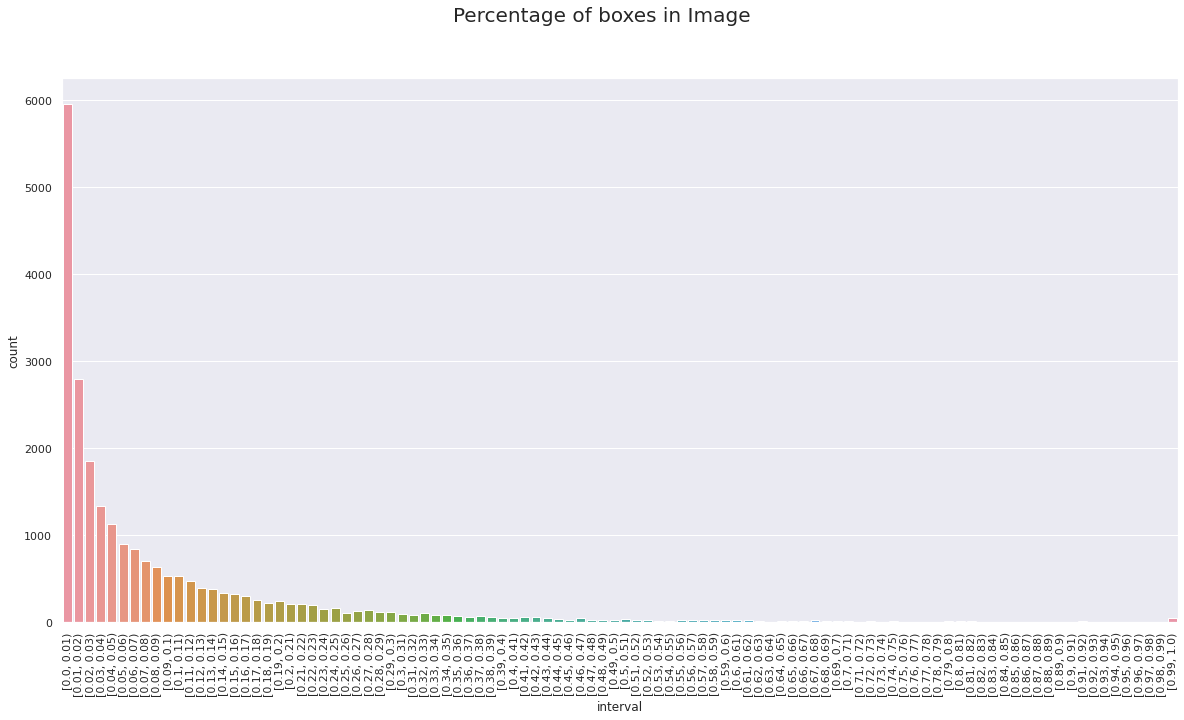

In [1363]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle("Percentage of boxes in Image", fontsize=20)
ax = sns.countplot(x="interval", data=box_df)
ax.tick_params(axis='x', rotation=90)

In [1364]:
box_df[box_df['box_ratio']>0.99].shape[0] # 이미지 전체가 bounding box인 경우 44개 존재

44

In [1365]:
print(box_df[box_df['box_ratio']<0.0001].shape[0]) # 이미지의 0.01%미만을 차지하는 bounding box가 3개 존재 => 확실히 outlier
print(box_df[box_df['box_ratio']<0.01].shape[0]) # 이미지의 1% 미만을 차지하는 bounding box 5951 존재 => outlier..? 시각화 필요

3
5951


### Bounding box ratio > 99%

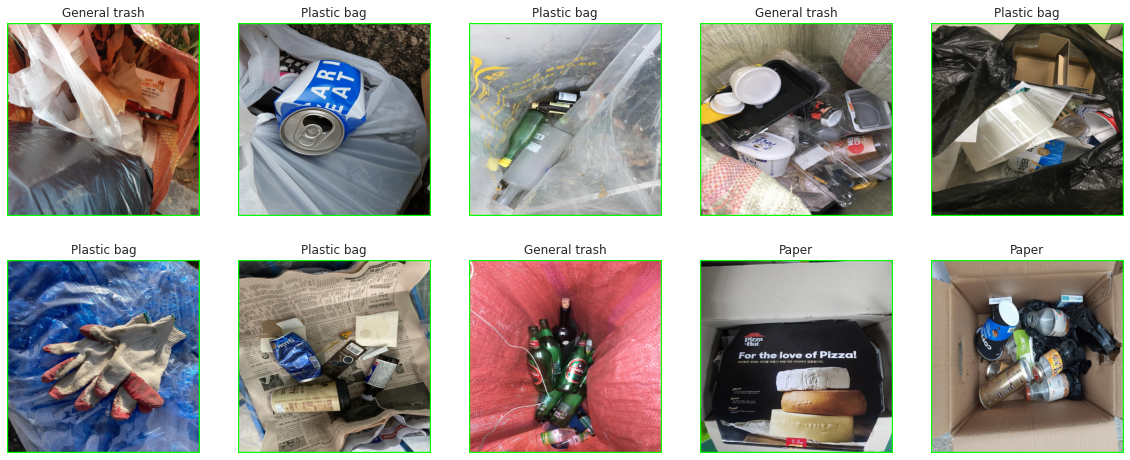

In [1251]:
fig , axes = plt.subplots(2,5)
fig.set_size_inches(20,8)

target_ids = list(box_df[box_df['box_ratio']>0.99]['bbox_id'].values)

for i, id_ in enumerate(random.sample(target_ids, 10)):
    img, label = draw_bbox(id_, l=10)
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_title(label)
    axes[i//5, i%5].axis('off')

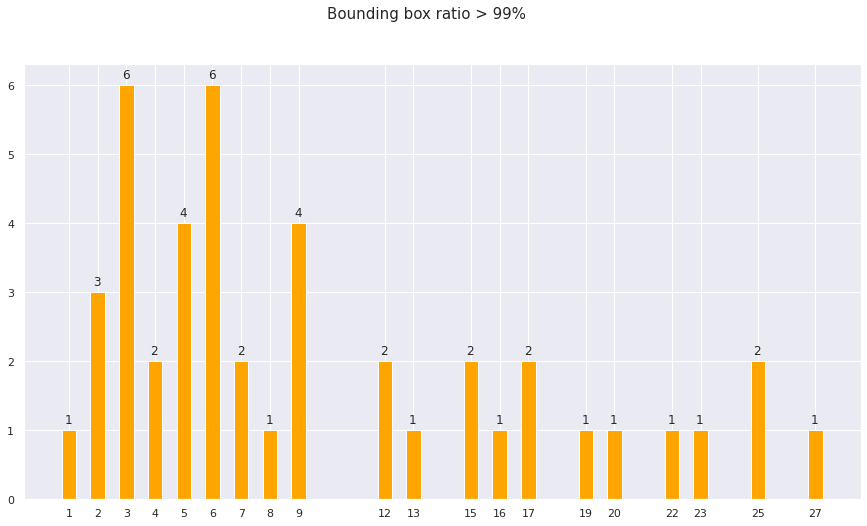

In [1177]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.suptitle('Bounding box ratio > 99% ', fontsize=15)
counter = box_df[box_df['box_ratio'] >0.99]['num_boxes_per_img'].value_counts().sort_index()
x = counter.keys()
data = counter.values
ax.bar(x, data, width=0.5, color='orange')
plt.xticks(x)
for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.095, p.get_height()+0.1))

In [1340]:
box_df[box_df['box_ratio']>=0.99]['label'].value_counts().sort_index() # 99%이상의 면적을 차지하는 객체의 레이블

0    16
1    14
5     2
7    11
9     1
Name: label, dtype: int64

### Bounding box ratio < 0.5%

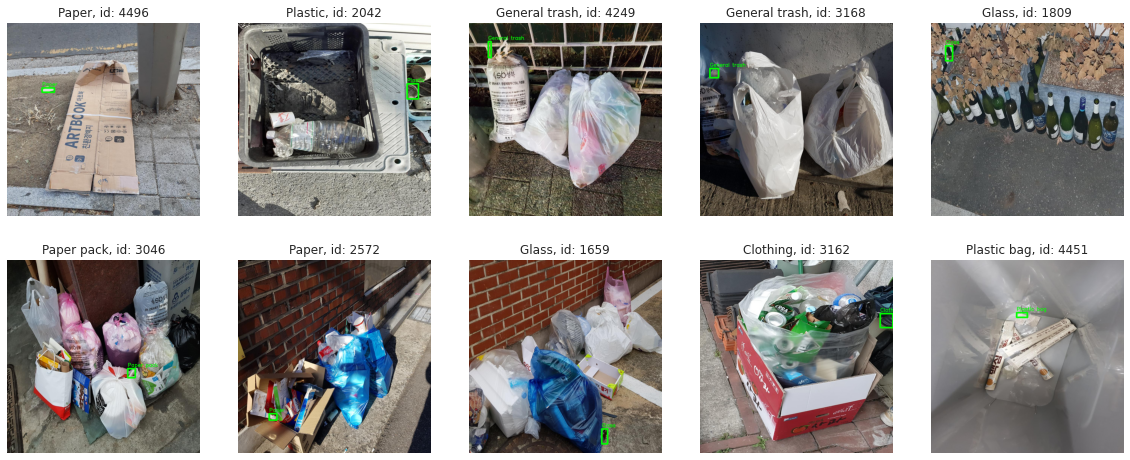

In [1343]:
fig , axes = plt.subplots(2,5)
fig.set_size_inches(20,8)

target_ids = list(box_df[box_df['box_ratio']<0.005]['bbox_id'].values)

for i, id_ in enumerate(random.sample(target_ids, 10)):
    img, label = draw_bbox(id_, l=8)
    img_id = train_json['annotations'][id_]['image_id']
    axes[i//5, i%5].imshow(img)
    axes[i//5, i%5].set_title(f'{label}, id: {img_id}')
    axes[i//5, i%5].axis('off')

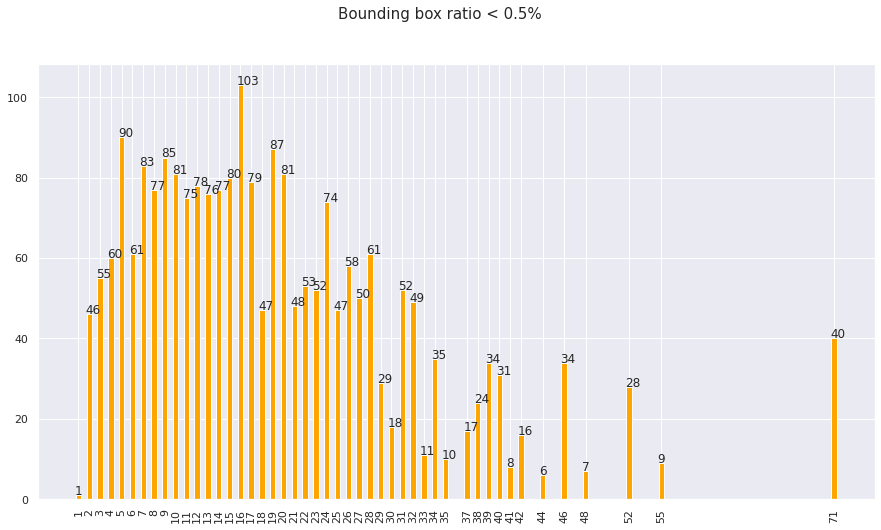

In [1371]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
fig.suptitle('Bounding box ratio < 0.5% ', fontsize=15)
counter = box_df[box_df['box_ratio'] < 0.003]['num_boxes_per_img'].value_counts().sort_index()
x = counter.keys()
data = counter.values
ax.bar(x, data, width=0.5, color='orange')
plt.xticks(x, rotation=90)

for p in ax.patches:
        ax.annotate('{}'.format(p.get_height()), (p.get_x()-0.095, p.get_height()+0.1))

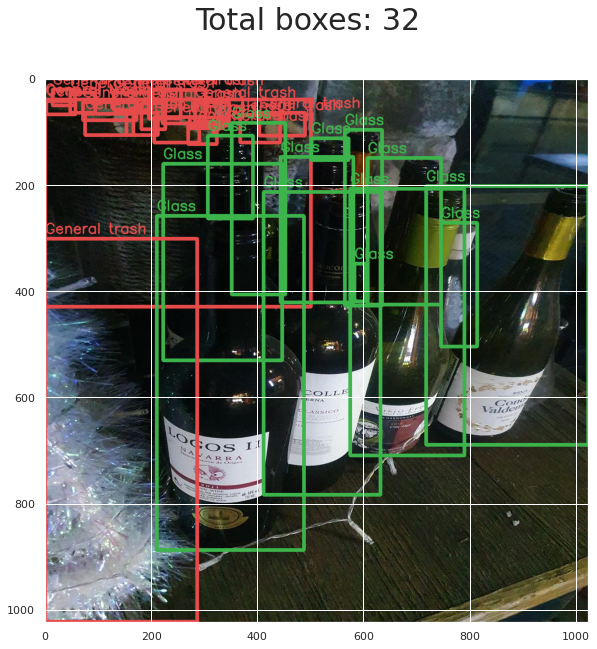

In [1281]:
index=833
draw_bboxes(index, draw=True, vis_label=True)

---

### 추가적으로 확인해볼 필요가 있는 image

- 약 0에 가까운 크기의 bounding box
- 이미지 전체 크기와 같은 bounding box
- 한 이미지에 71개의 bounding box가 존재하는 경우

In [763]:

small_box_image_index = train_json['annotations'][index_min]['image_id'] 
big_box_image_index = train_json['annotations'][index_max]['image_id']
many_boxes_in_image_index = num_boxes_per_image.index(71)

In [766]:
check_index = [small_box_image_index, big_box_image_index, many_boxes_in_image_index]
titles = ["Tiny box", "Big box", "71 boxes"]

In [1259]:
ann

{'image_id': 3242,
 'category_id': 2,
 'area': 7387.38,
 'bbox': [662.6, 433.1, 90.2, 81.9],
 'iscrowd': 0,
 'id': 15401}

In [1260]:
def draw_bboxes(index, title=None, l=5, draw=False, tiny=False, vis_label=False):
    '''
    이미지에 존재하는 모든 객체 시각화하는 함수
    '''
    annots = [i for i in train_json['annotations'] if i['image_id']==index]
    image = cv2.imread(path + '/train/{:04d}.jpg'.format(index))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for ann in annots:
        x,y,w,h = map(int, ann['bbox'])
        if tiny and (w*h > 0.0001):
            continue
        cv2.rectangle(image, (x,y), (x+w, y+h), color[ann['category_id']], l)
        
        if vis_label:
            cv2.putText(image, cat[ann['category_id']], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color[ann['category_id']], 2)
        
    if draw:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        plt.imshow(image)
        if title is not None:
            fig.suptitle(title, fontsize=30)
        else:
            fig.suptitle(f"Total boxes: {len(annots)}", fontsize=30)

        plt.show()
        return
    return image

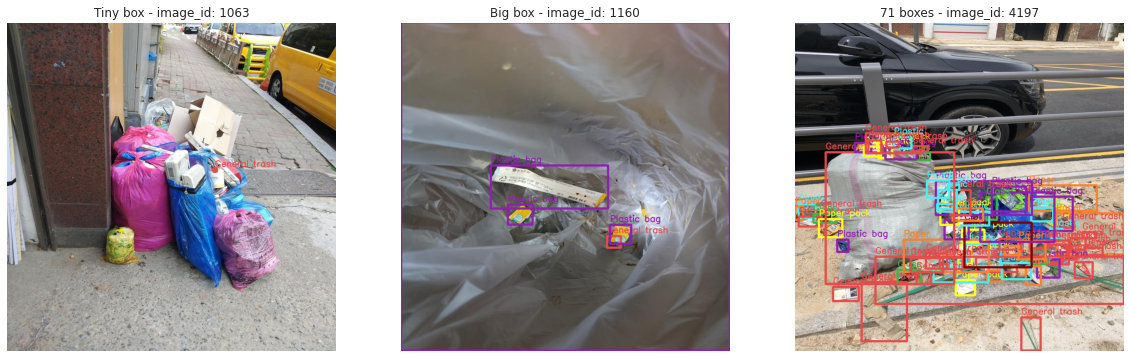

In [1262]:
fig , axes = plt.subplots(1,3)
fig.set_size_inches(20,8)

for i, (idx, title) in enumerate(zip(check_index, titles)):
    if title=='Tiny box':
        img = draw_bboxes(idx, l=20, tiny=True, vis_label=True)
    else:
        img = draw_bboxes(idx, tiny=False, vis_label=True)

    axes[i%3].imshow(img)
    axes[i%3].set_title(f"{title} - image_id: {idx}")
    axes[i%3].axis('off')

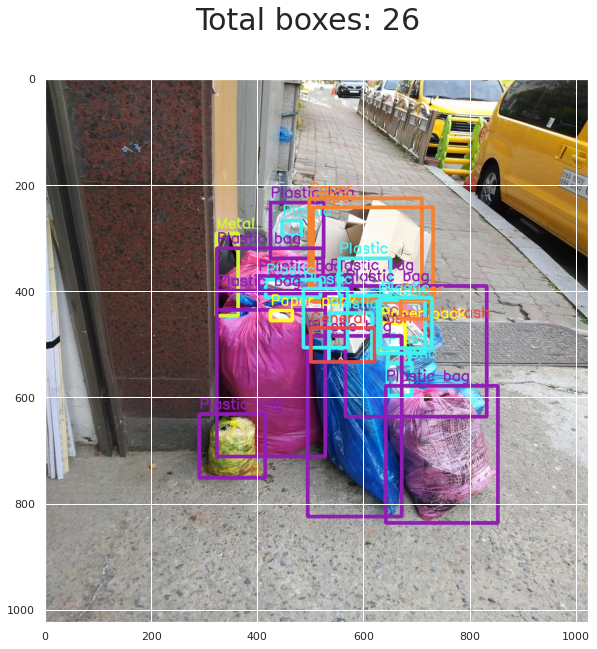

In [1346]:
draw_bboxes(1063, draw=True, vis_label=True)